In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#　VGG16を使用したぷろぐらむ
from PIL import Image
import os, glob
import numpy as np
from sklearn import model_selection

classes = ["fire_images", "non_fire_images"]
num_classes = len(classes)
image_size = 32

X = []
Y = []

# データの読み込み
for index, classlabel in enumerate(classes):
    photos_dir = f"/content/drive/My Drive/kiso4/{classlabel}"  # 各クラスフォルダのパス
    if not os.path.exists(photos_dir):
        print(f"フォルダが見つかりません: {photos_dir}")
        continue

    files = glob.glob(os.path.join(photos_dir, "*.png"))  # .pngファイルのみ対象
    for i, file in enumerate(files):
        try:
            image = Image.open(file)
            image = image.convert("RGB")  # RGB形式に変換
            image = image.resize((image_size, image_size))  # サイズ変更
            data = np.asarray(image)
            X.append(data)
            Y.append(index)
        except Exception as e:
            print(f"エラーが発生しました: {file}, エラー: {e}")

# NumPy配列に変換
X = np.array(X)
Y = np.array(Y)

# データをトレーニング用とテスト用に分割
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y)
xy = (X_train, X_test, y_train, y_test)
np.save("/content/drive/My Drive/kiso4/X_train.npy", X_train)
np.save("/content/drive/My Drive/kiso4/X_test.npy", X_test)
np.save("/content/drive/My Drive/kiso4/y_train.npy", y_train)
np.save("/content/drive/My Drive/kiso4/y_test.npy", y_test)

後でこれ使う
X_train = np.load("/content/drive/My Drive/kiso4/X_train.npy")
X_test = np.load("/content/drive/My Drive/kiso4/X_test.npy")
y_train = np.load("/content/drive/My Drive/kiso4/y_train.npy")
y_test = np.load("/content/drive/My Drive/kiso4/y_test.npy")

In [ ]:
# prompt:枚数を確認するコード
fire_images_dir = "/content/drive/My Drive/kiso4/fire_images"
non_fire_images_dir = "/content/drive/My Drive/kiso4/non_fire_images"

num_fire_images = len([f for f in os.listdir(fire_images_dir) if os.path.isfile(os.path.join(fire_images_dir, f))])
num_non_fire_images = len([f for f in os.listdir(non_fire_images_dir) if os.path.isfile(os.path.join(non_fire_images_dir, f))])

print(f"fire_imagesの枚数: {num_fire_images}")
print(f"non_fire_imagesの枚数: {num_non_fire_images}")

fire_imagesの枚数: 690
non_fire_imagesの枚数: 209


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.applications import VGG16
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

VGG16の全結合層抜きモデル


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Sequentialモデル


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 131,842 (515.01 KB)

 Trainable params: 131,842 (515.01 KB)

 Non-trainable params: 0 (0.00 B)

統合モデル


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 2)                   │         131,842 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,846,530 (56.64 MB)

 Trainable params: 14,846,530 (56.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/17
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 256ms/step - accuracy: 0.7575 - loss: 0.8109 - val_accuracy: 0.9067 - val_loss: 0.5474 - learning_rate: 1.0000e-04
Epoch 2/17
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9111 - loss: 0.5199 - val_accuracy: 0.9067 - val_loss: 0.5300 - learning_rate: 1.0000e-04
Epoch 3/17
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9226 - loss: 0.5115 - val_accuracy: 0.9200 - val_loss: 0.5246 - learning_rate: 1.0000e-04
Epoch 4/17
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9439 - loss: 0.4359 - val_accuracy: 0.9244 - val_loss: 0.4739 - learning_rate: 1.0000e-04
Epoch 5/17
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9662 - loss: 0.3709 - val_accuracy: 0.9244 - val_loss: 0.5251 - learning_rate: 1.0000e-04
Epoch 6/17
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9860 - loss: 0.3077
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9858 - l

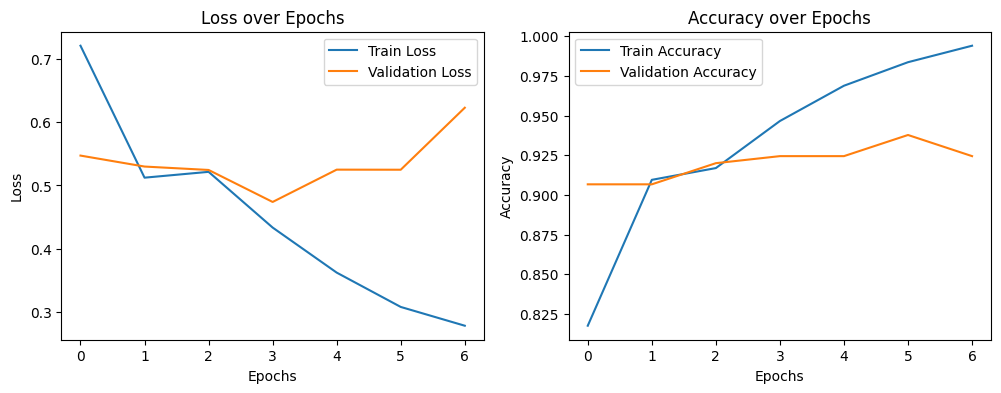

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16


classes = ["fire_images", "non_fire_images"]
num_classes = len(classes)
image_size = 32

#(2)
X_train = np.load("/content/drive/My Drive/kiso4/X_train.npy")
X_test = np.load("/content/drive/My Drive/kiso4/X_test.npy")
y_train = np.load("/content/drive/My Drive/kiso4/y_train.npy")
y_test = np.load("/content/drive/My Drive/kiso4/y_test.npy")

y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
X_train = X_train.astype("float") / 255.0
X_test = X_test.astype("float") /255.0

#(3)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))


print("VGG16の全結合層抜きモデル")
base_model.summary()

# 上位モデルの構築
top_model = Sequential([
    Flatten(input_shape=base_model.output_shape[1:]),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),  # L2正則化
    Dropout(0.6),  # 過学習対策でドロップアウト率を0.6に調整
    Dense(num_classes, activation='softmax')
])

print("Sequentialモデル")
top_model.summary()

# モデルの統合
model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

print("統合モデル")
model.summary()

#(4)転移学習用に一部の層を凍結
for layer in model.layers[:13]:
    layer.trainable = False

opt = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

# コールバックの設定（EarlyStopping & ReduceLROnPlateau）
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]


# 学習過程の可視化
history = model.fit(X_train, y_train, batch_size=32, epochs=17, validation_data=(X_test, y_test), callbacks=callbacks)

# 損失関数と精度の推移を可視化
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

score = model.evaluate(X_test, y_test, batch_size=32)

model.save("/content/drive/MyDrive/kiso4/firesort_cnn.h5")


In [ ]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
import csv

# クラス定義
classes = ["fire_images", "non_fire_images"]
num_classes = len(classes)
image_size = 32

# モデルの読み込み
model_path = "/content/drive/My Drive/kiso4/firesort_cnn.h5"
model = load_model(model_path)

# テストデータのディレクトリ
test_data_dir = "/content/drive/My Drive/kiso4/test_data"

# テストデータの画像分類
results = []
if os.path.exists(test_data_dir):
    for img_file in os.listdir(test_data_dir):
        try:
            # 画像の読み込みと前処理
            img_path = os.path.join(test_data_dir, img_file)
            image = Image.open(img_path)
            image = image.convert("RGB")
            image = image.resize((image_size, image_size))
            data = np.asarray(image) / 255.0
            X = np.array([data])

            # 予測実行
            result = model.predict([X])[0]
            predicted = result.argmax()
            percentage = int(result[predicted] * 100)

            # 結果をリストに追加
            results.append([img_file, classes[predicted], percentage])
            print(f"画像: {img_file} -> クラス: {classes[predicted]}, 確率: {percentage}%")

        except Exception as e:
            print(f"画像処理エラー: {img_file}, エラー: {e}")

# 結果をCSVに保存
output_csv = "/content/drive/My Drive/kiso4/test_results.csv"
with open(output_csv, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(["ファイル名", "予測クラス", "確率"])
    writer.writerows(results)

print(f"分類結果を {output_csv} に保存しました。")


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_3
Received: inputs=('Tensor(shape=(1, 32, 32, 3))',)
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
画像: non_fire.105.png -> クラス: non_fire_images, 確率: 99%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
画像: non_fire.10.png -> クラス: fire_images, 確率: 77%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
画像: non_fire.100.png -> クラス: non_fire_images, 確率: 99%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
画像: non_fire.110.png -> クラス: non_fire_images, 確率: 99%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
画像: non_fire.130.png -> クラス: non_fire_images, 確率: 96%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
画像: non_fire.120.png -> クラス: non_fire_images, 確率: 96%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
画像: non_fire.125.png -> クラス: non_fire_images, 確率: 99%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
画像: non_fire.140.png -> クラス: non_fire_images, 確率: 99%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
画像: non_fire.135.png -> クラス: non_fire_images, 確率: 98%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
画像: non_fire.115.png -> クラス: fire_images, 確率: 88%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
画像: non_fire.145.png -> クラス: non_fire_images, 確率: 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


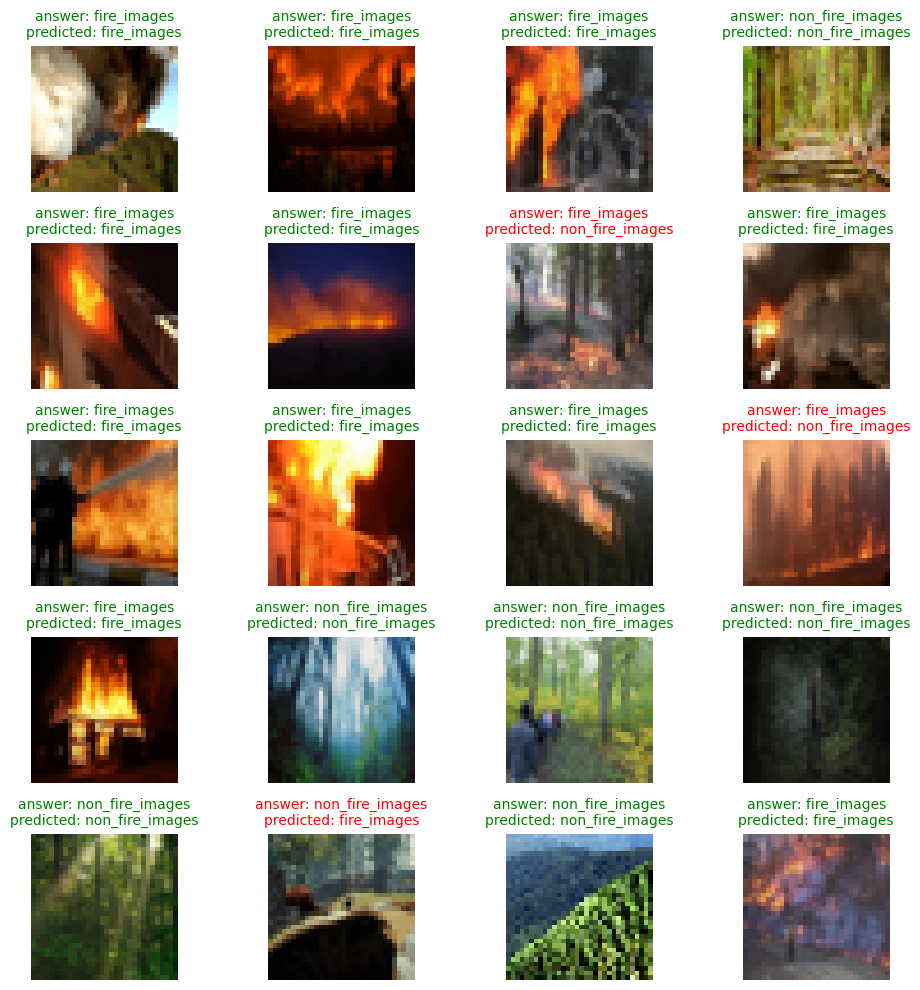

In [ ]:
import matplotlib.pyplot as plt

# テストデータで予測
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)  # 推定ラベル
y_true_labels = np.argmax(y_test, axis=1)  # 正解ラベル

# 画像とラベルを表示
num_images = 20  # 表示する画像の数
plt.figure(figsize=(10, 10))

for i in range(num_images):
    plt.subplot(5, 4, i + 1)  # 5行4列のグリッドで表示
    plt.imshow(X_test[i])  # 画像を表示
    plt.axis("off")  # 軸を非表示
    color = "green" if y_pred_labels[i] == y_true_labels[i] else "red"  # 正解なら緑、間違いなら赤

    # タイトルに正解ラベルと予測ラベルを表示
    plt.title(f"answer: {classes[y_true_labels[i]]}\npredicted: {classes[y_pred_labels[i]]}", color=color, fontsize=10)

plt.tight_layout()
plt.show()


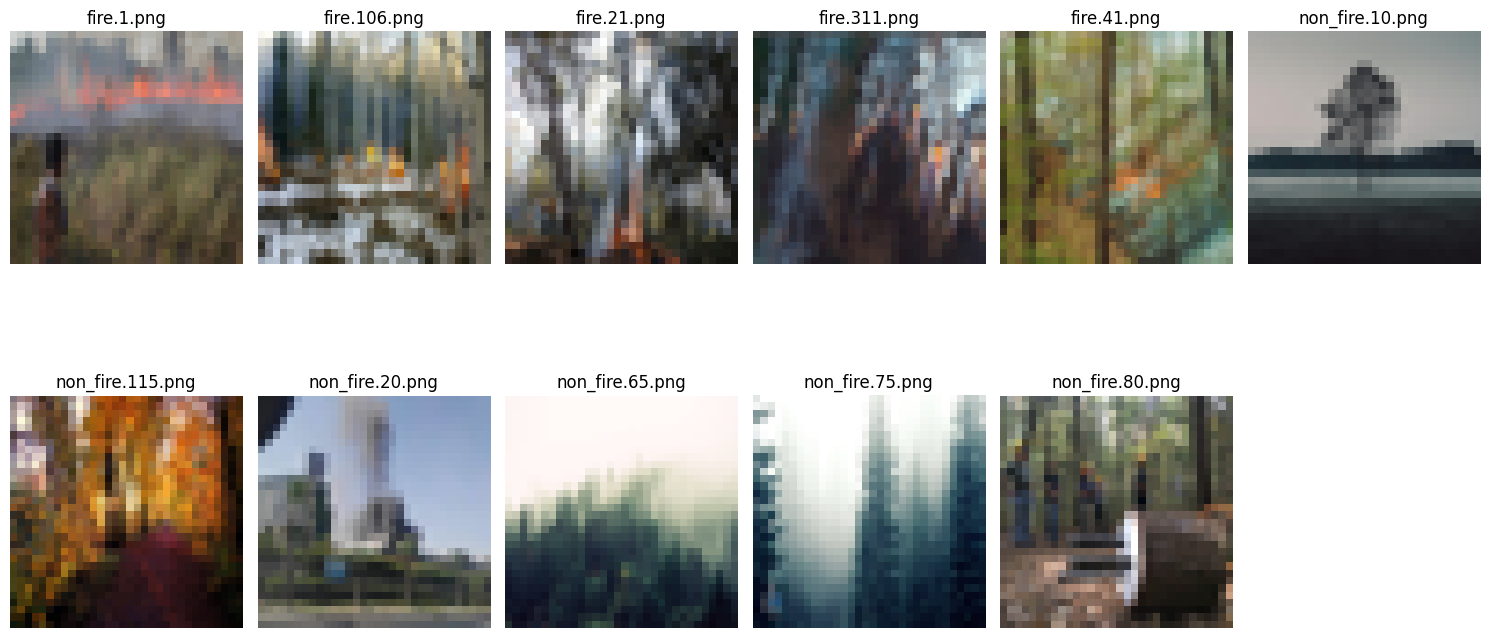

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

# ディレクトリのパス
directory = "/content/drive/My Drive/some/result"

# ファイル一覧を取得
files = sorted([f for f in os.listdir(directory) if f.endswith('.png')])

# 画像を2行に分ける設定
num_images = len(files)
num_rows = 2
num_cols = math.ceil(num_images / num_rows)  # 列数を計算

# サブプロットを設定
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))

# 各画像を表示
for i, file in enumerate(files):
    row = i // num_cols
    col = i % num_cols
    file_path = os.path.join(directory, file)
    img = mpimg.imread(file_path)

    axes[row, col].imshow(img)
    axes[row, col].set_title(file)  # ファイル名をタイトルに表示
    axes[row, col].axis('off')  # 軸を非表示

# 余分なプロットを非表示（画像数が列数×行数に満たない場合）
for i in range(num_images, num_rows * num_cols):
    fig.delaxes(axes.flat[i])

plt.tight_layout()
plt.show()
